# **[MED] [3D] [GEN] CT GAN**

A GAN based framework for adding and removing medical evidence in 3D volumetric medical scans

[![GitHub watch](https://img.shields.io/github/watchers/LeonidAlekseev/CT-GAN.svg?style=social&label=Watch&maxAge=2592000)](https://github.com/LeonidAlekseev/CT-GAN/)

## Environment

Create conda env with yml file and activate

```
conda env create -f environment.yml
conda activate ct_gan
```

In [1]:
!conda info --envs

# conda environments:
#
base                     /home/natitov/miniforge
avtostrah                /home/natitov/miniforge/envs/avtostrah
ct_gan                *  /home/natitov/miniforge/envs/ct_gan
ct_gan_test              /home/natitov/miniforge/envs/ct_gan_test
hack_lct                 /home/natitov/miniforge/envs/hack_lct



In [9]:
import warnings
import sys

warnings.filterwarnings("ignore")
sys.path.append('../')

## Data

### Load

In [6]:
!mkdir -p ~/.kaggle
!echo '{"username":"lifeadmin","key":"6f10a571b9c061cdbc37e224f50c42eb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
!mkdir -p ../data

!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer -p ../data
!unzip -qq ../data/medical-deepfakes-lung-cancer.zip -d ../data

!mv -v ../data/CT_Scans/EXP1_blind/* ../data/CT_Scans/
!mv -v ../data/CT_Scans/EXP2_open/* ../data/CT_Scans/

renamed '../data/CT_Scans/EXP1_blind/1003' -> '../data/CT_Scans/1003'
renamed '../data/CT_Scans/EXP1_blind/1005' -> '../data/CT_Scans/1005'
renamed '../data/CT_Scans/EXP1_blind/1009' -> '../data/CT_Scans/1009'
renamed '../data/CT_Scans/EXP1_blind/1045' -> '../data/CT_Scans/1045'
renamed '../data/CT_Scans/EXP1_blind/1067' -> '../data/CT_Scans/1067'
renamed '../data/CT_Scans/EXP1_blind/1201' -> '../data/CT_Scans/1201'
renamed '../data/CT_Scans/EXP1_blind/1219' -> '../data/CT_Scans/1219'
renamed '../data/CT_Scans/EXP1_blind/1280' -> '../data/CT_Scans/1280'
renamed '../data/CT_Scans/EXP1_blind/1356' -> '../data/CT_Scans/1356'
renamed '../data/CT_Scans/EXP1_blind/1402' -> '../data/CT_Scans/1402'
renamed '../data/CT_Scans/EXP1_blind/1411' -> '../data/CT_Scans/1411'
renamed '../data/CT_Scans/EXP1_blind/1438' -> '../data/CT_Scans/1438'
renamed '../data/CT_Scans/EXP1_blind/1452' -> '../data/CT_Scans/1452'
renamed '../data/CT_Scans/EXP1_blind/1531' -> '../data/CT_Scans/1531'
renamed '../data/CT_

In [3]:
import pandas as pd

labels_exp1 = pd.read_csv('../data/labels_exp1.csv')
labels_exp2 = pd.read_csv('../data/labels_exp2.csv')
labels = pd.concat((labels_exp1, labels_exp2), axis=0)
print(labels['type'].value_counts())
labels.head()

FB    72
FM    41
TM    35
TB    21
Name: type, dtype: int64


,type,uuid,slice,x,y
0,FB,1280,100,323,381
1,FB,1009,76,354,288
2,FB,7794,79,163,191
3,FB,7794,94,338,243
4,FB,2997,45,156,135


Classes

* True-Benign, (TB): A location that actually has no cancer
* True-Malicious (TM): A location that has real cancer
* False-Benign (FB): A location that has real cancer, but it was removed.
* False-Malicious (FM): A location that does not have cancer, but fake cancer was injected there.

In [ ]:
import os

healthy_scans_dir = '../data/healthy_scans/'
unhealthy_scans_dir = '../data/unhealthy_scans/'

os.makedirs(healthy_scans_dir)
os.makedirs(unhealthy_scans_dir)

In [5]:
healthy_scans = labels[labels['type'] == 'TB']
unhealthy_scans = labels[labels['type'] == 'TM']

healthy_coords = healthy_scans[['uuid', 'x', 'y', 'slice']]
unhealthy_coords = unhealthy_scans[['uuid', 'x', 'y', 'slice']]
healthy_coords.columns = ['filename', 'x', 'y', 'z']
unhealthy_coords.columns = ['filename', 'x', 'y', 'z']

healthy_coords.to_csv('../data/healthy_coords.csv', index=False)
unhealthy_coords.to_csv('../data/unhealthy_coords.csv', index=False)

In [36]:
import shutil

for uuid in healthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = healthy_scans_dir + uuid
  shutil.copytree(original, target)

for uuid in unhealthy_scans['uuid'].unique().astype(str):
  original = '../data/CT_Scans/' + uuid
  target = unhealthy_scans_dir + uuid
  shutil.copytree(original, target)

### Check

In [6]:
labels[labels['type'] == 'TM'].iloc[0]

type       TM
uuid     1546
slice     159
x         183
y         243
Name: 110, dtype: object

In [38]:
!python ../utils/dicom_to_nifti.py -i ../data/CT_Scans/1546 -o ../data/1546.nii.gz

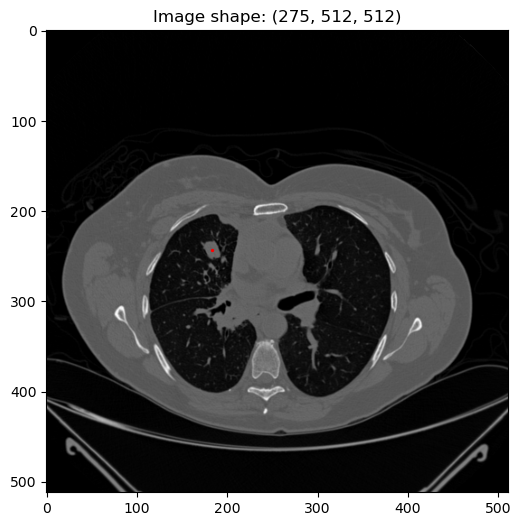

In [7]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img_path = '../data/1546.nii.gz'

test_image_nib = nib.load(img_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig = plt.figure(figsize=(12, 6))
plt.imshow(test_image[159], cmap='gray')
plt.scatter([183], [243], s=2, c='red')
plt.title(f'Image shape: {test_image.shape}')
plt.show()

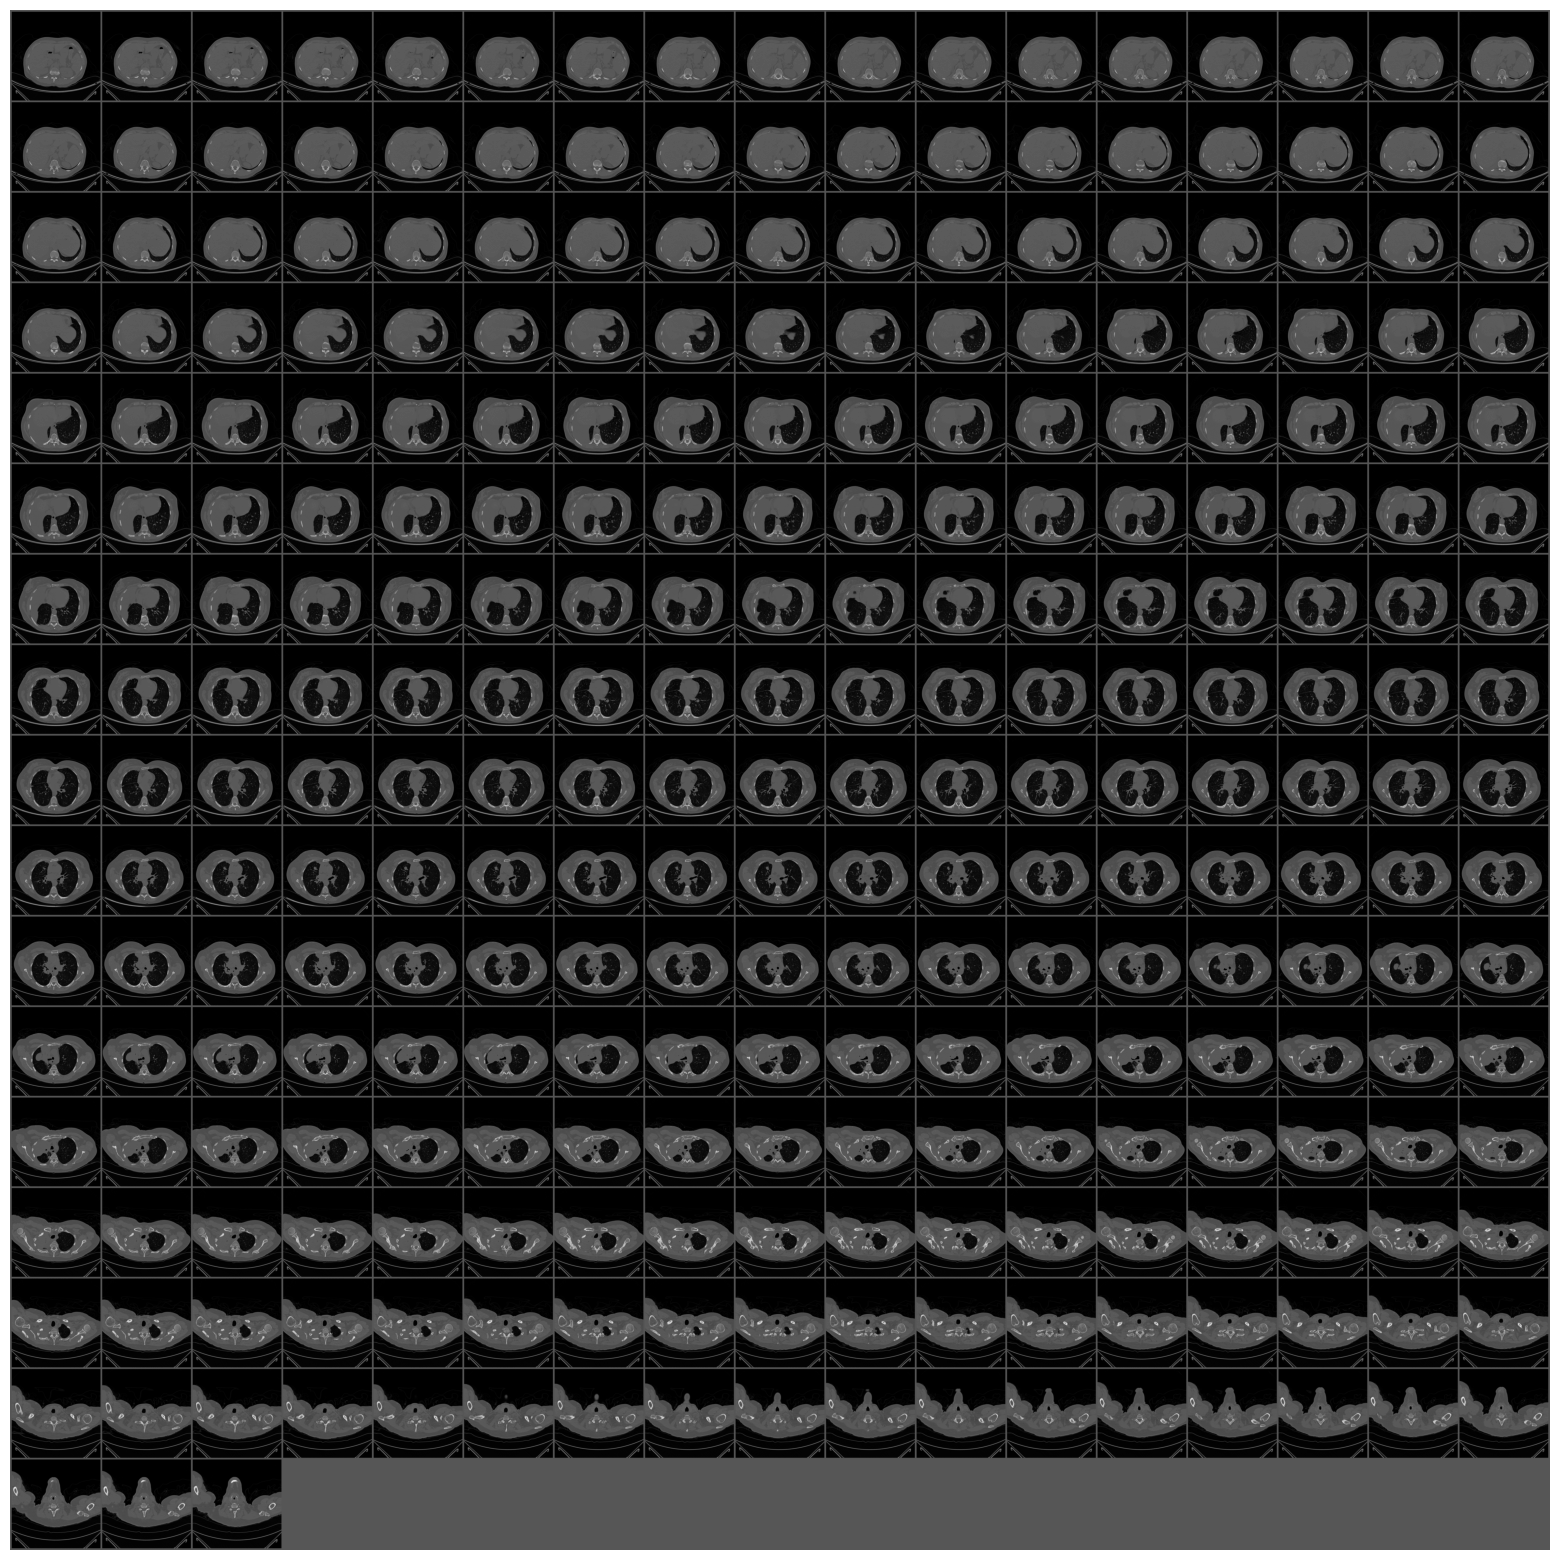

In [19]:
from skimage.util import montage

fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(test_image, padding_width=10, fill=1), cmap='gray')
plt.axis('off')
plt.show()

### Dataset

In [11]:
from procedures.datasetBuilder import Extractor

builder = Extractor(is_healthy_dataset=False, parallelize=False)
builder.extract()

preparing jobs...
extracting and augmenting samples...
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1546   vox coord (zyx):  [159 243 183]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/1045   vox coord (zyx):  [103 258 117]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 65 360 294]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 66 315  67]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [ 97 403 192]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/2244   vox coord (zyx):  [108 380 102]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 51 315 119]
Working on job: /home/natitov/hack_lct/leonid/CT-GAN/data/unhealthy_scans/6031   vox coord (zyx):  [ 64 290 240]
Working on job: /home/natitov/hack_lct/le

## Model

### Training process

In [ ]:
from procedures.trainer import Trainer

CTGAN_inj = Trainer(isInjector = True)
CTGAN_inj.train(epochs=200, batch_size=32, sample_interval=50)

### Inference process